In [1]:
%matplotlib inline

import tensorflow as tf
from train_channel_interval import get_batches
from preprocess import write_video
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
def put_kernels_on_grid (kernel, grid_Y, grid_X, pad = 1):

    '''Visualize conv. features as an image (mostly for the 1st layer).
    Place kernel into a grid, with some paddings between adjacent filters.

    Args:
      kernel:            tensor of shape [Y, X, NumChannels, NumKernels]
      (grid_Y, grid_X):  shape of the grid. Require: NumKernels == grid_Y * grid_X
                           User is responsible of how to break into two multiples.
      pad:               number of black pixels around each filter (between them)

    Return:
      Tensor of shape [(Y+2*pad)*grid_Y, (X+2*pad)*grid_X, NumChannels, 1].
    '''

    x_min = tf.reduce_min(kernel)
    x_max = tf.reduce_max(kernel)

    kernel1 = (kernel - x_min) / (x_max - x_min)

    # pad X and Y
    x1 = tf.pad(kernel1, tf.constant( [[pad,pad],[pad, pad],[0,0],[0,0]] ), mode = 'CONSTANT')

    # X and Y dimensions, w.r.t. padding
    Y = kernel1.get_shape()[0] + 2 * pad
    X = kernel1.get_shape()[1] + 2 * pad

    channels = kernel1.get_shape()[2]

    # put NumKernels to the 1st dimension
    x2 = tf.transpose(x1, (3, 0, 1, 2))
    # organize grid on Y axis
    x3 = tf.reshape(x2, tf.pack([grid_X, Y * grid_Y, X, channels])) #3

    # switch X and Y axes
    x4 = tf.transpose(x3, (0, 2, 1, 3))
    # organize grid on X axis
    x5 = tf.reshape(x4, tf.pack([1, X * grid_X, Y * grid_Y, channels])) #3

    # back to normal order (not combining with the next step for clarity)
    x6 = tf.transpose(x5, (2, 1, 3, 0))

    # to tf.image_summary order [batch_size, height, width, channels],
    #   where in this case batch_size == 1
    x7 = tf.transpose(x6, (3, 0, 1, 2))

    # scale to [0, 255] and convert to uint8
    return tf.image.convert_image_dtype(x7, dtype = tf.uint8) 

def visualize(tensor):
    weights = tensor.eval()
    assert(weights.shape[0] == weights.shape[1])
    width = weights.shape[0]
    channels = weights.shape[2]
    filters = weights.shape[3]
    
    tiling = math.ceil(math.sqrt(channels * filters))
    output_width = tiling * width
    output = np.zeros((output_width, output_width))
    row, col = 0, 0
    for i in range(channels):
        for j in range(filters):
            output[width*row:width*(row+1),width*col:width*(col+1)] = weights[:,:,i,j]
            col += 1
            if col == tiling:
                col = 0
                row += 1
            
    return output

def get_summaries(tensor, name):
    channels = tf.split(2, tensor.get_shape()[2], tensor)
    tensors = []
    for t in channels:
        tensors += tf.split(3, int(t.get_shape()[3]) / 16, t)
    
    return [tf.image_summary("{}/{}".format(name, i), put_kernels_on_grid(w, 4, 4), max_images=1) for (i,w) in enumerate(tensors)]

def bias(num_units, init):
    return tf.Variable(tf.constant(init, shape=[num_units]))

def weights(shape, stddev):
    return tf.Variable(tf.truncated_normal(shape, stddev=stddev))

def conv2d(inp, b, w):
    return tf.nn.relu(tf.nn.conv2d(inp, w, strides=[1,1,1,1], padding='SAME') + b)

def pool3d(inp):
    return tf.nn.max_pool3d(inp, ksize=[1, 2, 2, 2, 1], strides=[1, 2, 2, 2, 1], padding='SAME')

def layer(inp, num_units, filter_shape):
    b = bias(num_units, 0.2)
    w = weights(filter_shape + [num_units], 0.04)
    conv = [conv2d(i, b, w) for i in inp]
    i_pool = tf.pack(conv, axis=1)
    o_pool = pool3d(i_pool)
    out = tf.unpack(o_pool, axis=1)
    return b,w,conv,i_pool,o_pool,out

def dense(inp, num_in, num_out, b_init, w_init):
    b = bias(num_out, b_init)
    w = weights([num_in, num_out], w_init)
    h = tf.nn.relu(tf.matmul(inp, w) + b)
    
    return b, w, h

def dense_multi(inp, num_in, num_out, b_init, w_init):
    b = bias(num_out, b_init)
    w = weights([num_in, num_out], w_init)
    unpacked = tf.unpack(inp, axis=1)
    h = [tf.nn.relu(tf.matmul(i, w) + b) for i in unpacked]
    return b, w, tf.pack(h, axis=1)

def flatten(inp):
    packed = tf.pack(inp, axis=1)
    shape = packed.get_shape()[1:].num_elements()
    reshaped = tf.reshape(packed, [-1, shape])
    return reshaped, shape

def flatten_multi(inp):
    packed = tf.pack(inp, axis=1)
    shape = packed.get_shape()[2:].num_elements()
    reshaped = tf.reshape(packed, [-1, 32, shape])
    return reshaped, shape

In [3]:
x_h = tf.placeholder(tf.float32, shape=[None, 32, 64, 64, 2])
x_m = tf.placeholder(tf.float32, shape=[None, 32, 64, 64, 2])

inp_h = tf.unpack(x_h, axis=1)
inp_m = tf.unpack(x_m, axis=1)
y = tf.placeholder(tf.float32, shape=[None, 20])

# Convolutional layers, hand
b_conv1_h, w_conv1_h, h_conv1_h, i_pool1_h, o_pool1_h, i_conv2_h = layer(inp_h, 16, [5, 5, 2])
b_conv2_h, w_conv2_h, h_conv2_h, i_pool2_h, o_pool2_h, i_conv3_h = layer(i_conv2_h, 32, [5, 5, 16])
b_conv3_h, w_conv3_h, h_conv3_h, i_pool3_h, o_pool3_h, o_h = layer(i_conv3_h, 48, [4, 4, 32])
flat_h, shape_h = flatten(o_h)
b_fc1_h, w_fc1_h, h_fc1_h = dense(flat_h, shape_h, 256, 0.1, 0.02)

# Convolutional layers, main
b_conv1_m, w_conv1_m, h_conv1_m, i_pool1_m, o_pool1_m, i_conv2_m = layer(inp_m, 16, [5, 5, 2])
b_conv2_m, w_conv2_m, h_conv2_m, i_pool2_m, o_pool2_m, i_conv3_m = layer(i_conv2_m, 32, [5, 5, 16])
b_conv3_m, w_conv3_m, h_conv3_m, i_pool3_m, o_pool3_m, o_m = layer(i_conv3_m, 48, [4, 4, 32])
flat_m, shape_m = flatten(o_m)
b_fc1_m, w_fc1_m, h_fc1_m = dense(flat_m, shape_m, 256, 0.1, 0.02)

# Fully-connected layers
i_fc2 = tf.concat(1, [h_fc1_h, h_fc1_m])
#b_fc1, w_fc1, h_fc1 = dense(tf.concat(1, [flat_h, flat_m]), shape_h + shape_m, 512, 0.1, 0.02)
b_fc2 = bias(20, 0.1)
w_fc2 = weights([512, 20], 0.02)
h_fc2 = tf.matmul(i_fc2, w_fc2) + b_fc2

# Computations
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(h_fc2, y))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(h_fc2,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [4]:
CHALAP = "/media/amey/76D076A5D0766B6F/chalap"
MODEL = "channel-interval"

# Create variables
step = 0
sess = tf.InteractiveSession()
summary_writer = tf.train.SummaryWriter("{}/summaries/{}".format(CHALAP, MODEL), sess.graph)
saver = tf.train.Saver()
accuracy_summary = tf.placeholder(tf.float32, [])

# Initialize/restore
sess.run(tf.initialize_all_variables())
#saver.restore(sess, "{}/checkpoints/{}-9".format(CHALAP, MODEL))

# Create summary tensors
image_summaries = get_summaries(w_conv1_h, "conv1") + \
                  get_summaries(w_conv2_h, "conv2") + \
                  get_summaries(w_conv3_h, "conv3")
accuracy_summary_op = tf.scalar_summary("train_accuracy", accuracy_summary)

In [6]:
for epoch in range(20):
    acc = []
    batches = get_batches(batch_size, seq_len, 1, 400)
    for i,batch in enumerate(batches):
        step += 1
        train_accuracy, _ = sess.run([accuracy, train_step], feed_dict={x_h:batch[0], x_m:batch[1], y: batch[2]})
        acc.append(train_accuracy)
        if i%100 == 0:
            cumulative = sum(acc) / len(acc)
            print("step %d, training accuracy %g"%(i, cumulative))
            summary_writer.add_summary(accuracy_summary_op.eval(feed_dict={accuracy_summary: cumulative}), step)

    saver.save(sess, "{}/checkpoints/{}/checkpoint".format(CHALAP, MODEL), global_step=epoch)
    
    val_batches = get_batches(batch_size, seq_len, 401, 470)
    val_cumulative = 0
    val_acc = []
    for j,batch in enumerate(val_batches):
        val_accuracy = sess.run(accuracy, feed_dict={x_h:batch[0], x_m:batch[1], y: batch[2]})
        val_acc.append(val_accuracy)
        
    print("Done with epoch: %d, validation accuracy %g" % (epoch, sum(val_acc) / len(val_acc)))

step 0, training accuracy 0.25
step 100, training accuracy 0.0326733
step 200, training accuracy 0.040796
step 300, training accuracy 0.0438538
step 400, training accuracy 0.0720698
step 500, training accuracy 0.0774451
step 600, training accuracy 0.0892679
step 700, training accuracy 0.102782
step 800, training accuracy 0.106742
step 900, training accuracy 0.123363
step 1000, training accuracy 0.133816
step 1100, training accuracy 0.14119
step 1200, training accuracy 0.158868
step 1300, training accuracy 0.17475
step 1400, training accuracy 0.182976
step 1500, training accuracy 0.195769
step 1600, training accuracy 0.203342
step 1700, training accuracy 0.218695
step 1800, training accuracy 0.226041
step 1900, training accuracy 0.23627
step 2000, training accuracy 0.249875
step 2100, training accuracy 0.257996
step 2200, training accuracy 0.268242
step 2300, training accuracy 0.270535
step 2400, training accuracy 0.28107
step 2500, training accuracy 0.289444
step 2600, training accurac

In [ ]:
temp1 = flat.eval(feed_dict={x_h: b[0], x_m: b[1], y: b[2]})

In [ ]:
w_fc1.eval()

In [ ]:
np.argmax(b[2], axis=1)

In [7]:
temp = [0, 0.0391089, 0.0552239, 0.0681063, 0.0798005, 0.0886228, 0.0995008, 0.109986, 0.117665, 0.1303, 0.140859, 0.144233, 0.161116, 0.173059, 0.178872, 0.188208, 0.193723, 0.206761, 0.212104, 0.221173, 0.232459, 0.240909, 0.247524, 0.247414, 0.25429, 0.261795, 0.270473, 0.280822, 0.289611, 0.294467, 0.299017, 0.304337, 0.311434, 0.313822, 0.323515, 0.329557, 0.339488, 0.347166, 0.35237, 0.357994, 0.362684, 0.368431, 0.375907, 0.379322, 0.385152, 0.39152, 0.398754, 0.403431, 0.408724, 0.413022, 0.418018, 0.422239, 0.426831, 0.433569, 0.439183, 0.444452, 0.446901, 0.451127, 0.457403, 0.463241, 0.469026, 0.474395, 0.477633, 0.48136, 0.485483, 0.489563, 0.49114, 0.496665, 0.501252, 0.50716, 0.512618, 0.515817, 0.520185, 0.523769, 0.527611, 0.532401, 0.536655, 0.541304, 0.545207, 0.549363, 0.553216, 0.557299, 0.560053, 0.563818, 0.567146, 0.570975, 0.575298, 0.579024, 0.582705, 0.585873, 0.588869, 0.592445, 0.596416, 0.599618, 0.60314, 0.605333, 0.608445, 0.611461, 0.614337, 0.615345, 0.618714, 0.621611, 0.62506, 0.628297, 0.6305, 0.633277, 0.636221, 0.639186, 0.642142, 0.645089, 0.647917, 0.650436, 0.653182, 0.655937, 0.658571, 0.660358, 0.662632, 0.665135, 0.667371, 0.669846, 0.672297, 0.674739, 0.676967, 0.679099, 0.681443, 0.683797, 0.685996, 0.688204, 0.689512, 0.691531, 0.693285, 0.695062, 0.695832, 0.69794, 0.699844, 0.701901, 0.70393, 0.705122, 0.707053, 0.708953, 0.710883, 0.712749, 0.714645, 0.716165, 0.717788, 0.719504, 0.72128, 0.722847, 0.724396, 0.725702, 0.727367, 0.728895, 0.730597, 0.732143, 0.733658, 0.735111, 0.736555, 0.738188, 0.739683, 0.741041, 0.742528, 0.743251, 0.744712, 0.745887, 0.747065, 0.747544, 0.749004, 0.75011, 0.751555, 0.753018, 0.753831, 0.755207, 0.756537, 0.757854, 0.75891, 0.760014, 0.761172, 0.762452, 0.763707, 0.765018, 0.766226, 0.767131, 0.768026, 0.769239, 0.770381, 0.771507, 0.772613, 0.773731, 0.77481, 0.775824, 0.77683, 0.77791, 0.779005, 0.780128, 0.780599, 0.781684, 0.782723, 0.783603, 0.783953, 0.784981, 0.785976, 0.787053, 0.788098, 0.788758, 0.789649, 0.790639, 0.791604, 0.792448, 0.793112, 0.793939, 0.794721, 0.795659, 0.796598, 0.797529, 0.798326, 0.799199, 0.800116, 0.800974, 0.801853, 0.802723, 0.803597, 0.804274, 0.805081, 0.805904, 0.806616, 0.807297, 0.808115, 0.808379, 0.809172, 0.809898, 0.810571, 0.810845, 0.811572, 0.812178, 0.812864, 0.81362, 0.814125, 0.814788, 0.815455, 0.816153, 0.816826, 0.817529, 0.81821, 0.818937, 0.819641, 0.820298, 0.821028, 0.821703, 0.822345, 0.823052, 0.823712, 0.824413, 0.825111, 0.825791, 0.826468, 0.827097, 0.827734, 0.828311, 0.828946, 0.829526, 0.829676, 0.83031, 0.830891, 0.831413, 0.831608, 0.83218, 0.83267, 0.833262, 0.833859, 0.834345, 0.834948, 0.835554, 0.836137, 0.836581, 0.837078, 0.837523, 0.838064, 0.83859, 0.839151, 0.839728, 0.840248, 0.840767, 0.841327, 0.841848, 0.842372, 0.842837, 0.843358, 0.843911, 0.84443, 0.84492, 0.845459, 0.845976, 0.846485, 0.846574, 0.847085, 0.84759, 0.848054, 0.848227, 0.848712, 0.849148, 0.849639, 0.850144, 0.850573, 0.851052, 0.851549, 0.852034, 0.852465, 0.852912, 0.853336, 0.853708, 0.854168, 0.854594, 0.854994, 0.855349, 0.85578, 0.856212, 0.856538, 0.856954, 0.857348, 0.857785, 0.858227, 0.858547, 0.858983, 0.859392, 0.859771, 0.86011, 0.860157, 0.860538, 0.860923, 0.86125, 0.861392, 0.861808, 0.862211, 0.862624, 0.863034, 0.863379, 0.86366, 0.864046, 0.86445, 0.864839, 0.865216, 0.865553, 0.865933, 0.866323, 0.866698, 0.867082, 0.867444, 0.867804, 0.86817, 0.868542, 0.868895, 0.869233, 0.8696, 0.869959, 0.870283, 0.870615, 0.870936, 0.871273, 0.871629, 0.871643, 0.871942, 0.87228, 0.87259, 0.872699, 0.873037, 0.873367, 0.873716, 0.874056, 0.874389, 0.874718, 0.875061, 0.875399, 0.875736, 0.876072, 0.876381, 0.876701, 0.877028, 0.87736, 0.877687, 0.878014, 0.878341, 0.878655, 0.87892, 0.879209, 0.879518, 0.879784, 0.880091, 0.880301, 0.880608, 0.880914, 0.881221, 0.881527, 0.881531, 0.881794, 0.882016, 0.882253, 0.882336, 0.88261, 0.882881, 0.88316, 0.883443, 0.88372, 0.883992, 0.884268, 0.88453, 0.884795, 0.885062, 0.88532, 0.885601, 0.885861, 0.886127, 0.886392, 0.88666, 0.886864, 0.887063, 0.887285, 0.887557, 0.887808, 0.888056, 0.88828, 0.888534, 0.888791, 0.889051, 0.88931, 0.889567, 0.889544, 0.889804, 0.890054, 0.890281, 0.890362, 0.890597, 0.890829, 0.891081, 0.891329, 0.891552, 0.891805, 0.892049, 0.892287, 0.892513, 0.892747, 0.892969, 0.893213, 0.893459, 0.893703, 0.893946, 0.894176, 0.894405, 0.894633, 0.89487, 0.895098, 0.89532, 0.895552, 0.895768, 0.895989, 0.896207, 0.896433, 0.89666, 0.896885, 0.896874, 0.897094, 0.89725, 0.897447, 0.89752, 0.897732, 0.897938, 0.898153, 0.898367, 0.89858, 0.898798, 0.899009, 0.89919, 0.899391, 0.899594, 0.899748, 0.899946, 0.900147, 0.900359, 0.900538, 0.900694, 0.900899, 0.901101, 0.901304, 0.901485, 0.901617, 0.901776, 0.901979, 0.902182, 0.902373, 0.902572, 0.902771, 0.90295, 0.902925, 0.903124, 0.903321, 0.903504, 0.903567, 0.903751, 0.903943, 0.90414, 0.904332, 0.904495, 0.904688, 0.90488, 0.905071, 0.905264, 0.905454, 0.905623, 0.905797, 0.905977, 0.906117, 0.906253, 0.906409, 0.906584, 0.906761, 0.906939, 0.907122, 0.907305, 0.907478, 0.907657, 0.907835, 0.908012, 0.908192, 0.908345, 0.908512, 0.908512, 0.908684, 0.908827, 0.90899, 0.909044, 0.909215, 0.909366, 0.90952, 0.909639, 0.909799, 0.909966, 0.910135, 0.910304, 0.91047, 0.910639, 0.910792, 0.910949, 0.911114, 0.91128, 0.911385, 0.911532, 0.911691, 0.911833, 0.911971, 0.912107, 0.912254, 0.912411, 0.912562, 0.912709, 0.912868, 0.913025, 0.913185, 0.913342, 0.913378, 0.913533, 0.913682, 0.913832, 0.913884, 0.91404, 0.914192, 0.914346, 0.914499, 0.914643, 0.914796, 0.914947, 0.915099, 0.915251, 0.915401, 0.915521, 0.91566, 0.915783, 0.915926, 0.916075, 0.916222, 0.916357, 0.91646, 0.916595, 0.916732, 0.916871, 0.91701, 0.917154, 0.917289, 0.917429, 0.917571, 0.917713, 0.917854, 0.91791, 0.918039, 0.918178, 0.918314, 0.91836, 0.918497, 0.918633, 0.918771, 0.918906, 0.919031, 0.919161, 0.919279, 0.919406, 0.919535, 0.919649, 0.919736, 0.91984, 0.919954, 0.920073, 0.920204, 0.92032, 0.920446, 0.920571, 0.920699, 0.920831, 0.920949, 0.921056, 0.92118, 0.921309, 0.921438, 0.921564, 0.921676, 0.921798, 0.921823, 0.921948, 0.922057, 0.92217, 0.92221, 0.922336, 0.922456, 0.92257, 0.922681, 0.922789, 0.92287, 0.922982, 0.92308, 0.923197, 0.923314, 0.923402, 0.923511, 0.923631, 0.923744, 0.923865, 0.923985, 0.924105, 0.924225, 0.924342, 0.924461, 0.92458, 0.924698, 0.924816, 0.924929, 0.925038, 0.925148, 0.925235, 0.925314, 0.925302, 0.925403, 0.92547, 0.925573]
x_axis = range(len(temp))

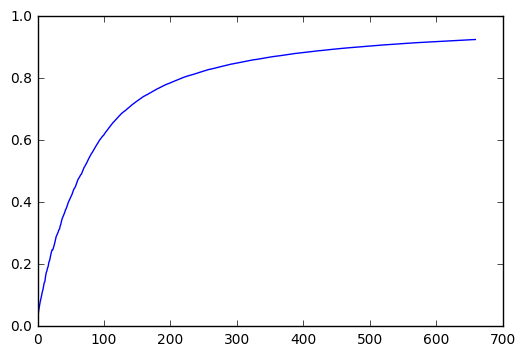

In [9]:
plt.plot(x_axis, temp)